# RLHF Diffusion Fine-Tuning for Age, Gender, Ethnicity, Emotion
We will:
1. Load dataset and metadata.
2. Preprocess images and labels.
3. Inject LoRA into U-Net.
4. Use Textual Prompt Embeddings.
5. Train the model.
6. Inference for conditioned image generation.


In [1]:
# Install necessary packages
# !pip install pandas Pillow tqdm torch torchvision transformers diffusers scikit-learn IProgress ipywidgets accelerate peft matplotlib

In [ ]:
# Imports and Configuration
import os
import gc
import uuid
import json
import random
import numpy as np
import pandas as pd
import shutil
import gradio as gr
from PIL import Image as PILImage # Typed Annotation for Image
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, Dict, List, Optional, Any
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import transforms

from diffusers import StableDiffusionPipeline

from transformers import CLIPTokenizer

from peft import LoraConfig

In [3]:
# RUN_ID: str = str(uuid.uuid4()).replace('-', '')[:6]
# print(f"RUN_ID: {RUN_ID}")

# Define Batch Size
batch_size: int = 2

# Dataset Paths
dataset_root: Path = Path('./datasets/appa-real-dataset_v2')
labels_md_train = dataset_root / 'labels_metadata_train.csv'
labels_md_valid = dataset_root / 'labels_metadata_valid.csv'
labels_md_test  = dataset_root / 'labels_metadata_test.csv'

ds_train = dataset_root / 'train_data'
ds_valid = dataset_root / 'valid_data'
ds_test  = dataset_root / 'test_data'

# Load Metadata
df_md_train = pd.read_csv(labels_md_train)
df_md_valid = pd.read_csv(labels_md_valid)
df_md_test  = pd.read_csv(labels_md_test)

print(f"Train: {df_md_train.shape}, Valid: {df_md_valid.shape}, Test: {df_md_test.shape}")

Train: (4065, 5), Valid: (1482, 5), Test: (1978, 5)


In [4]:
class ImageWithPromptDataset(Dataset):
    def __init__(
        self,
        df_md: pd.DataFrame,
        images_dir: Path,
        tokenizer: CLIPTokenizer,
        transform: Optional[transforms.Compose],
    ):
        self.df = df_md
        self.images_dir = images_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def build_prompt(self,row):
        age_desc = f"{int(row['age'])} years old"
        gender_desc = row['gender']
        ethnicity_desc = row['ethnicity']

        # Emotion mapping
        emotion_map = {
            'neutral': "with a neutral expression",
            'happy': "smiling happily",
            'slightlyhappy': "smiling slightly",
            'other': "showing a subtle emotion"
        }
        emotion_desc = emotion_map.get(row['emotion'], "with an expression")  # fallback if unknown

        prompt = f"A {age_desc} {ethnicity_desc} {gender_desc} {emotion_desc}"
        return prompt

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        img_name = f"{int(row['imageId']):06d}.jpg"
        img_path = self.images_dir / img_name

        image = PILImage.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        prompt = self.build_prompt(row)
        prompt_ids = self.tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids[0]

        return {
            'pixel_values': image,
            'prompt_ids': prompt_ids
        }

In [5]:
# Data Transforms & Loaders
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Resize((512, 512)), # Stable Diffusion 1.5 resolution
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Resize((512, 512)), # Stable Diffusion 1.5 resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageWithPromptDataset(df_md_train, ds_train, tokenizer, transform=train_transform)
valid_dataset = ImageWithPromptDataset(df_md_valid, ds_valid, tokenizer, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
# --------------------------------------------------------------------------------------------------
## Helper Functions
# --------------------------------------------------------------------------------------------------

def load_model(
    lora_r: int = 64,
    lora_alpha: int = 64,
    lora_dropout: float = 0.05,
    device: str = 'cuda',
    verbose: bool = False
) -> StableDiffusionPipeline:
    """
    Loads the Stable Diffusion pipeline with LoRA configuration and ensures correct trainable parameters.

    Args:
        lora_r (int): LoRA rank.
        lora_alpha (int): LoRA alpha scaling.
        lora_dropout (float): Dropout probability for LoRA.
        device (str): Device to load the model onto.
        verbose (bool): If True, prints additional details during initialization.

    Returns:
        StableDiffusionPipeline: The configured pipeline ready for training.
    """

    # 1. Load base pipeline
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16
    ).to(device)
    print("✅ Base model loaded.")

    # 2. Define LoRA PEFT config
    peft_lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["to_q", "to_v"],
        lora_dropout=lora_dropout,
        bias="none"
    )

    # 3. Add LoRA Adapter
    pipe.unet.add_adapter(adapter_name="age_gender_lora", adapter_config=peft_lora_config)
    print("✅ LoRA adapter added.")

    # 4. Enable LoRA layers for training
    pipe.unet.enable_lora()
    print("✅ LoRA adapter enabled for training.")

    # 5. Freeze VAE & Text Encoder
    pipe.vae.requires_grad_(False)
    pipe.text_encoder.requires_grad_(False)
    print("✅ VAE and Text Encoder frozen.")

    # --- 💡 CRITICAL CHANGE: Check if LoRA weights are non-zero (i.e., resumed)
    is_resumed_run = False
    # Check if a LoRA_A weight tensor exists and its sum is non-zero
    for name, module in pipe.unet.named_modules():
        if hasattr(module, 'lora_A') and hasattr(module.lora_A, 'weight'):
            if module.lora_A.weight.sum() != 0:
                is_resumed_run = True
                break
    
    # 6. Initialize LoRA_B weights if this is a NEW run and weights are zero
    # This prevents re-initializing trained weights on a resumed run.
    print("\n🔍 Initializing LoRA_B weights if this is a new run...")
    for name, module in pipe.unet.named_modules():
        if hasattr(module, 'lora_B'):
            # Check for the actual weight tensor and confirm it's a new run
            if not is_resumed_run and hasattr(module.lora_B, 'weight') and module.lora_B.weight.abs().sum() == 0:
                torch.nn.init.kaiming_uniform_(module.lora_B.weight)
                if verbose:
                    print(f" - Initialized lora_B for {name}")

    # 7. Debug and Verification
    print("\n🔍 Checking LoRA Layers Injected into UNet...")
    lora_param_count = 0
    for name, param in pipe.unet.named_parameters():
        if 'lora' in name:
            lora_param_count += 1
            param_dtype = param.dtype
            nan_inf = torch.isnan(param).any() or torch.isinf(param).any()
            if verbose: print(f" - {name}: shape={param.shape}, mean={param.data.mean():.6f}, std={param.data.std():.6f}, dtype={param_dtype}, requires_grad={param.requires_grad}, nan/inf={nan_inf}")

    if lora_param_count == 0:
        raise RuntimeError("❌ No LoRA parameters found in UNet! Injection failed.")

    # 8. Ensure ONLY LoRA Layers Are Trainable
    non_lora_trainable = [n for n, p in pipe.unet.named_parameters() if p.requires_grad and 'lora' not in n]
    if non_lora_trainable:
        print("❌ ERROR: Found non-LoRA parameters set to requires_grad=True:")
        for n in non_lora_trainable:
            print(f" - {n}")
        raise RuntimeError("Non-LoRA params are trainable! You must freeze them explicitly.")
    else:
        print("✅ Only LoRA layers are trainable.")

    print("\n🚀 LoRA setup successful. Ready for training loop.")
    return pipe

def unload_model(pipe: StableDiffusionPipeline) -> None:
    """
    Unloads the UNet from the pipeline and clears GPU memory.

    Args:
        pipe (StableDiffusionPipeline): The current pipeline to unload from.
    """
    print("🔻 Unloading UNet to free GPU memory...")
    del pipe.unet
    torch.cuda.empty_cache()
    gc.collect()
    print("✅ UNet unloaded and GPU cache cleared.")

def setup_run_logging(
    output_base_dir: Path,
    resume_unet_checkpoint_path: Optional[Path] = None
) -> Dict[str, Any]:
    """
    Sets up the logging directory for a training run, generates a RUN_ID,
    and determines if the run is new or resumed.
    """
    is_resumed_run = False
    run_dir = None
    
    if resume_unet_checkpoint_path and resume_unet_checkpoint_path.exists():
        is_resumed_run = True
        
        # --- 💡 Updated Logic Here ---
        # Traverse up the path to find the run directory name.
        # This assumes the structure is run_dir/lora_checkpoints/
        run_dir_name = resume_unet_checkpoint_path.parent.parent.name
        run_id = run_dir_name
        
        run_dir = output_base_dir / run_id
        if not run_dir.exists():
            print(f"Warning: Resuming from checkpoint but expected run directory {run_dir} not found. Creating it.")
            run_dir.mkdir(parents=True, exist_ok=True)
            
        print(f"🔄 Resuming existing run with RUN_ID: {run_id}")
    else:
        # New run
        run_id = f"{str(uuid.uuid4()).replace('-', '')[:6]}_run_{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}"
        run_dir = output_base_dir / run_id
        run_dir.mkdir(parents=True, exist_ok=True)
        print(f"✨ Starting new run with RUN_ID: {run_id}")
    
    history_file = run_dir / "training_history.json"
    (run_dir / "lora_checkpoints").mkdir(exist_ok=True)
    (run_dir / "lora_samples").mkdir(exist_ok=True)
    
    return {
        "run_id": run_id,
        "run_dir": run_dir,
        "history_file": history_file,
        "is_resumed_run": is_resumed_run
    }

def load_or_resume_history(history_file: Path, is_resumed_run: bool) -> Dict[str, List[Dict[str, Any]]]:
    """Loads existing training history or initializes a new one."""
    training_history = {"epochs": []}
    if is_resumed_run and history_file.exists():
        with open(history_file, 'r') as f:
            training_history = json.load(f)
        print(f"📊 Loaded existing training history from {history_file}")
    return training_history

def save_best_checkpoints(
    pipe: StableDiffusionPipeline,
    output_dir: Path,
    current_epoch_number: int,
    current_loss: float,
    best_loss: float,
) -> Tuple[bool, Path, Path]:
    """
    Saves checkpoints only if the current loss is an improvement over the best loss.
    Deletes the previous best checkpoint to save space.

    Args:
        pipe (StableDiffusionPipeline): The training pipeline.
        output_dir (Path): The directory to save checkpoints.
        current_epoch_number (int): The current epoch number.
        current_loss (float): The average training loss for the current epoch.
        best_loss (float): The best loss recorded so far.

    Returns:
        Tuple[bool, Path, Path]: A tuple containing a boolean indicating if a save occurred,
                                 and the paths to the saved LoRA adapter and full checkpoint.
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Do not save if the loss has not improved.
    if current_loss >= best_loss:
        print(f"📉 Epoch {current_epoch_number}: Loss did not improve. Best loss remains {best_loss:.6f}.")
        # Return a boolean indicating that no save happened, and dummy paths.
        return False, Path(""), Path("")

    # --- Loss has improved, so we save and remove the old checkpoint ---
    print(f"🏆 Epoch {current_epoch_number}: Loss improved from {best_loss:.6f} to {current_loss:.6f}! Saving model...")

    # Define paths for the new best checkpoints
    best_lora_adapter_save_path = output_dir / "best_lora_adapter"
    best_full_unet_checkpoint_path = output_dir / "best_full_unet_checkpoint.pth"

    # Remove old checkpoints if they exist
    if best_lora_adapter_save_path.exists():
        try:
            shutil.rmtree(best_lora_adapter_save_path)
            print("✅ Removed old best LoRA adapter directory.")
        except OSError as e:
            print(f"❌ Error removing old best LoRA adapter: {e}")

    if best_full_unet_checkpoint_path.exists():
        try:
            best_full_unet_checkpoint_path.unlink()
            print("✅ Removed old best full U-Net checkpoint file.")
        except OSError as e:
            print(f"❌ Error removing old full U-Net checkpoint: {e}")

    # Save the new best checkpoints
    pipe.unet.save_pretrained(best_lora_adapter_save_path, adapter_name="age_gender_lora")
    torch.save(pipe.unet.state_dict(), best_full_unet_checkpoint_path)
    
    print(f"Saved new best LoRA adapter at {best_lora_adapter_save_path}")
    print(f"Saved new best full U-Net checkpoint at {best_full_unet_checkpoint_path}")

    # Return a boolean indicating a save happened, and the new paths.
    return True, best_lora_adapter_save_path, best_full_unet_checkpoint_path

def generate_and_save_sample(
    pipe: StableDiffusionPipeline,
    dataset: Dataset,
    sample_dir: Path,
    current_epoch_number: int,
    device: str
) -> Tuple[PILImage.Image, str, Path, Path]:
    """Generates a sample image, saves it with its prompt, and returns the results."""
    sample_dir.mkdir(parents=True, exist_ok=True)
    sample_row = random.choice(dataset.df.to_dict(orient="records"))
    sample_prompt: str = dataset.build_prompt(sample_row)
    generator = torch.Generator(device=device).manual_seed(42)

    with torch.no_grad():
        with torch.amp.autocast(device):
            image = pipe(prompt=sample_prompt, num_inference_steps=75, guidance_scale=7.5, generator=generator).images[0]

    image_save_path = sample_dir / f"sample_epoch_{current_epoch_number}.png"
    image.save(image_save_path)
    print(f"Saved sample image at {image_save_path}")

    prompt_save_path = sample_dir / f"sample_epoch_{current_epoch_number}_prompt.txt"
    with open(prompt_save_path, 'w') as file:
        file.write(sample_prompt)
    print(f"Saved prompt to {prompt_save_path}")

    return image, sample_prompt, image_save_path, prompt_save_path

def display_image_with_prompt(image: PILImage.Image, prompt: str, current_epoch_number: int) -> None:
    """Displays a generated image along with its prompt using matplotlib."""
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Epoch {current_epoch_number} Sample\nPrompt: {prompt}", wrap=True)
    plt.axis('off')
    plt.show()

# --------------------------------------------------------------------------------------------------
## The Refactored `train_lora_diffusion` function
# --------------------------------------------------------------------------------------------------

def train_lora_diffusion(
    num_epochs: int,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    dataset_for_sampling: Dataset,
    learning_rate: float = 3e-5,
    lora_r: int = 64,
    lora_alpha: int = 64,
    lora_dropout: float = 0.05,
    gradient_checkpoint_enable: bool = True,
    gradient_accumulation_steps: int = 1,
    output_base_dir: Path = Path("./lora_training_runs"),
    resume_unet_checkpoint_path: Optional[Path] = None,
    device: str = 'cuda',
    verbose: bool = False,
    use_gradio: bool = False
) -> Optional[gr.Blocks]:

    def _training_loop_generator():
      # --- (Existing setup code) ---
      run_info = setup_run_logging(output_base_dir, resume_unet_checkpoint_path)
      run_dir, history_file, is_resumed_run = run_info["run_dir"], run_info["history_file"], run_info["is_resumed_run"]
      output_dir = run_dir / "lora_checkpoints"
      sample_dir = run_dir / "lora_samples"

      training_history = load_or_resume_history(history_file, is_resumed_run)
      start_epoch = len(training_history["epochs"])
      total_epochs = start_epoch + num_epochs
      
      # We handle output based on the `use_gradio` flag later
      if use_gradio:
          yield {"status": f"🚀 Training from epoch {start_epoch + 1} for a total of {total_epochs} epochs."}
      else:
          print(f"🚀 Training from epoch {start_epoch + 1} for a total of {total_epochs} epochs.")

      # --- CRITICAL FIX: The dtype argument is removed from the load_model function call. ---
      pipe: StableDiffusionPipeline = load_model(lora_r, lora_alpha, lora_dropout, device)
      
      # Manually cast the model components to float32 after loading
      pipe.unet = pipe.unet.to(torch.float32)
      pipe.vae = pipe.vae.to(torch.float32)
      pipe.text_encoder = pipe.text_encoder.to(torch.float32)
      
      pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

      if gradient_checkpoint_enable:
          status_msg = "✅ Gradient checkpointing enabled."
      else:
          status_msg = "✅ Gradient checkpointing is not enabled."
      if use_gradio: yield {"status": status_msg}
      else: print(status_msg)
      
      # Get trainable parameters, which are now in float32
      lora_params = [p for n, p in pipe.unet.named_parameters() if p.requires_grad]
      optimizer = torch.optim.AdamW(lora_params, lr=learning_rate)
      
      # --- REMOVED: GradScaler for full precision training ---
      # The GradScaler and its related functions are not needed for full-precision training.

      scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
      
      if use_gradio: yield {"status": "✅ Using CosineAnnealingWarmRestarts scheduler."}
      else: print("✅ Using CosineAnnealingWarmRestarts scheduler.")

      # --- Initialize best_loss ---
      best_loss = float('inf')
      if is_resumed_run and training_history['epochs']:
          best_loss = min(e['train_loss'] for e in training_history['epochs'])
          if use_gradio: yield {"status": f"📊 Resuming from history. Initial best loss: {best_loss:.6f}"}
          else: print(f"📊 Resuming from history. Initial best loss: {best_loss:.6f}")

      # --- Main Training Loop ---
      for epoch in range(start_epoch, total_epochs):
          pipe.unet.train()
          total_loss = 0.0
          processed_batches = 0
          current_epoch_number = epoch + 1

          tqdm_pbar = tqdm(train_dataloader, desc=f"Epoch {current_epoch_number}/{total_epochs}")
          for batch_idx, batch in enumerate(tqdm_pbar):
              pixel_values = batch['pixel_values'].to(device, dtype=torch.float32)
              
              with torch.no_grad():
                  latents = pipe.vae.encode(pixel_values).latent_dist.sample()
                  latents = latents * 0.18215
              
              noise = torch.randn_like(latents)
              timesteps = torch.randint(10, pipe.scheduler.config.num_train_timesteps, (latents.shape[0],), device=device).long()
              noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
              prompt_ids = batch['prompt_ids'].to(device)
              
              with torch.no_grad():
                  encoder_hidden_states = pipe.text_encoder(prompt_ids)[0]
              
              # --- The entire forward pass and loss are now in float32 ---
              model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
              
              loss = nn.functional.mse_loss(model_pred, noise, reduction="mean")
              loss = loss / gradient_accumulation_steps
              
              loss.backward()
              total_loss += loss.item() * gradient_accumulation_steps

              if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
                  torch.nn.utils.clip_grad_norm_(lora_params, max_norm=1.0)
                  optimizer.step()
                  optimizer.zero_grad()
                  processed_batches += gradient_accumulation_steps
          
          # --- End of Epoch Logic (Updated) ---
          avg_loss = total_loss / processed_batches if processed_batches > 0 else 0.0
          scheduler.step()
          current_lr = scheduler.get_last_lr()[0]

          is_saved, lora_path, unet_path = save_best_checkpoints(
              pipe, output_dir, current_epoch_number, avg_loss, best_loss
          )
          
          if is_saved:
              best_loss = avg_loss
          
          image, prompt, image_path, prompt_path = generate_and_save_sample(
              pipe, dataset_for_sampling, sample_dir, current_epoch_number, device
          )

          epoch_history = {
              "epoch": current_epoch_number,
              "train_loss": avg_loss,
              "best_loss": best_loss,
              "saved_this_epoch": is_saved,
              "sample_prompt": prompt,
              "sample_image_path": str(image_path),
              "lora_adapter_path": str(lora_path) if is_saved else None,
              "full_unet_checkpoint_path": str(unet_path) if is_saved else None,
              "learning_rate": current_lr
          }
          training_history["epochs"].append(epoch_history)

          with open(history_file, 'w') as f:
              json.dump(training_history, f, indent=4)
          
          if use_gradio:
              yield {
                  "epoch": current_epoch_number,
                  "train_loss": avg_loss,
                  "learning_rate": current_lr,
                  "sample_image": image,
                  "sample_prompt": prompt,
                  "history_log": epoch_history,
                  "status": f"✅ Epoch {current_epoch_number}/{total_epochs} completed. Loss: {avg_loss:.6f}. Best Loss: {best_loss:.6f}"
              }
          else:
              print(f"Epoch [{current_epoch_number}/{total_epochs}] Average Loss: {avg_loss:.6f}, Learning Rate: {current_lr:.6e}")
              print(f"Best Loss so far: {best_loss:.6f}")
              print(f"Updated training history saved to {history_file}")
              display_image_with_prompt(image, prompt, current_epoch_number)
              
      unload_model(pipe)
      if use_gradio:
          yield {"status": "✨ Training complete! Model unloaded."}
      else:
          print("✨ Training complete! Model unloaded.")
          
    # --- Conditional Execution based on `use_gradio` flag ---
    if use_gradio:
      with gr.Blocks(title="LoRA Training Dashboard") as demo:
          gr.Markdown("# LoRA Training Dashboard 🚀")
          with gr.Row():
              with gr.Column(scale=1):
                  with gr.Accordion("Training Settings", open=True):
                      num_epochs_input = gr.Slider(label="Number of Epochs", minimum=1, maximum=100, value=num_epochs, step=1)
                      lr_input = gr.Number(label="Learning Rate", value=learning_rate)
                      lora_r_input = gr.Slider(label="LoRA Rank (r)", minimum=1, maximum=256, value=lora_r, step=1)
                      lora_alpha_input = gr.Slider(label="LoRA Alpha", minimum=1, maximum=256, value=lora_alpha, step=1)
                      lora_dropout_input = gr.Number(label="LoRA Dropout", value=lora_dropout)
                      grad_accum_input = gr.Slider(label="Gradient Accumulation Steps", minimum=1, maximum=16, value=gradient_accumulation_steps, step=1)
                  start_button = gr.Button("Start Training", variant="primary")
                  status_box = gr.Textbox(label="Status", lines=2)
                  history_box = gr.JSON(label="Last Epoch Details")
              with gr.Column(scale=2):
                  gr.Markdown("### Training Loss")
                  loss_plot = gr.Plot(value=pd.DataFrame({"Epoch": [], "Loss": []}))
                  gr.Markdown("### Sample Generation")
                  with gr.Row():
                      sample_image_output = gr.Image(label="Generated Sample", width=512)
                      sample_prompt_output = gr.Textbox(label="Prompt", lines=5)

          training_history_df = {"Epoch": [], "Loss": []}
          def update_gradio_plot_and_status(generator_outputs):
              nonlocal training_history_df
              if "train_loss" in generator_outputs:
                  training_history_df["Epoch"].append(generator_outputs["epoch"])
                  training_history_df["Loss"].append(generator_outputs["train_loss"])
                  df = pd.DataFrame(training_history_df)
                  return {
                      loss_plot: gr.update(value=df, x="Epoch", y="Loss", title="Training Loss over Epochs"),
                      sample_image_output: gr.update(value=generator_outputs["sample_image"]),
                      sample_prompt_output: gr.update(value=generator_outputs["sample_prompt"]),
                      status_box: gr.update(value=generator_outputs["status"]),
                      history_box: gr.update(value=generator_outputs["history_log"])
                  }
              else:
                  return {
                      status_box: gr.update(value=generator_outputs["status"]),
                  }

          start_button.click(
              fn=_training_loop_generator,
              inputs=[
                  num_epochs_input, lr_input, lora_r_input, lora_alpha_input, lora_dropout_input, grad_accum_input
              ],
              outputs=[loss_plot, sample_image_output, sample_prompt_output, status_box, history_box],
          )
      
      return demo
    else:
      for _ in _training_loop_generator():
          pass
      return None

# --- Example Usage ---
# In a Jupyter Notebook:
# demo = train_lora_diffusion(..., use_gradio=True)
# if demo:
#     demo.launch()

# In a standard Python script or for backward compatibility:
# train_lora_diffusion(..., use_gradio=False)

In [8]:
# Random Sample of ImageDataSet Prompt
dataset = train_loader.dataset
sample_row = random.choice(dataset.df.to_dict(orient="records"))
sample_prompt = dataset.build_prompt(sample_row)
print(sample_prompt)

A 2 years old caucasian male with a neutral expression


✨ Starting new run with RUN_ID: af641a_run_20250805-173847
🚀 Training from epoch 1 for a total of 10 epochs.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_49636/1239622916.py:283: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


✅ Base model loaded.
✅ LoRA adapter added.
✅ LoRA adapter enabled for training.
✅ VAE and Text Encoder frozen.

🔍 Initializing LoRA_B weights if this is a new run...

🔍 Checking LoRA Layers Injected into UNet...
✅ Only LoRA layers are trainable.

🚀 LoRA setup successful. Ready for training loop.
✅ Gradient checkpointing enabled.
✅ Using CosineAnnealingWarmRestarts scheduler.


Epoch 1/10: 100%|██████████| 2033/2033 [37:08<00:00,  1.10s/it]


Epoch [1/10] Average Loss: 0.119375, Learning Rate: 2.714480e-04
Saved LoRA adapter weights only at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/lora_adapters_epoch_1
Saved full U-Net checkpoint (including LoRA state) at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/full_unet_checkpoint_epoch_1.pth


  0%|          | 0/75 [00:00<?, ?it/s]

Saved sample image at lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_1.png
Saved prompt to lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_1_prompt.txt


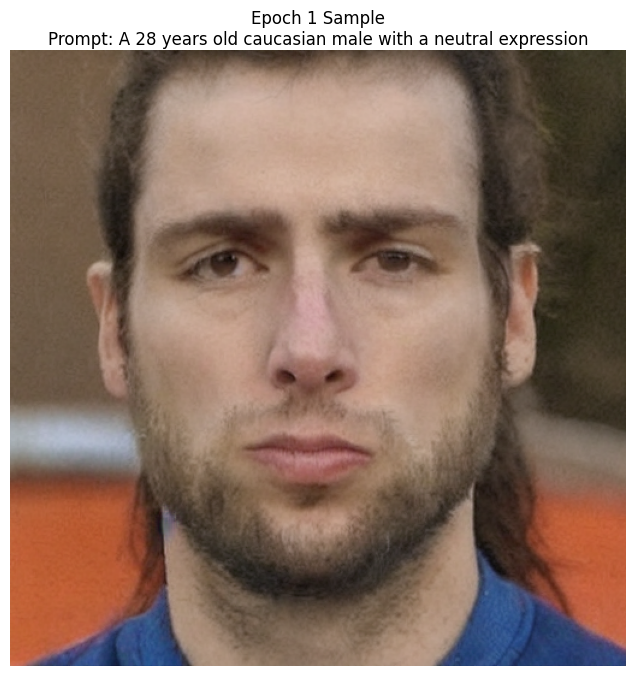

Updated training history saved to lora_training_runs/af641a_run_20250805-173847/training_history.json


Epoch 2/10: 100%|██████████| 2033/2033 [35:31<00:00,  1.05s/it]


Epoch [2/10] Average Loss: 0.120384, Learning Rate: 1.966980e-04
Saved LoRA adapter weights only at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/lora_adapters_epoch_2
Saved full U-Net checkpoint (including LoRA state) at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/full_unet_checkpoint_epoch_2.pth


  0%|          | 0/75 [00:00<?, ?it/s]

Saved sample image at lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_2.png
Saved prompt to lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_2_prompt.txt


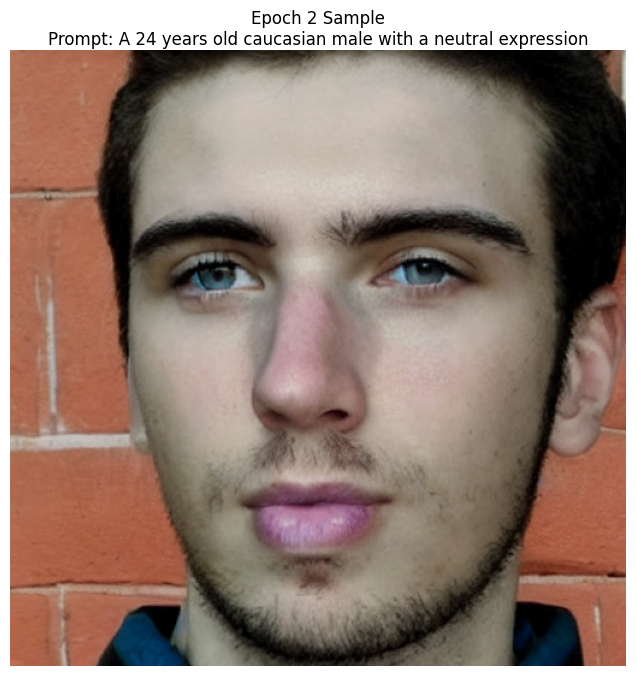

Updated training history saved to lora_training_runs/af641a_run_20250805-173847/training_history.json


Epoch 3/10: 100%|██████████| 2033/2033 [36:43<00:00,  1.08s/it]


Epoch [3/10] Average Loss: 0.117514, Learning Rate: 1.043020e-04
Saved LoRA adapter weights only at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/lora_adapters_epoch_3
Saved full U-Net checkpoint (including LoRA state) at lora_training_runs/af641a_run_20250805-173847/lora_checkpoints/full_unet_checkpoint_epoch_3.pth


  0%|          | 0/75 [00:00<?, ?it/s]

Saved sample image at lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_3.png
Saved prompt to lora_training_runs/af641a_run_20250805-173847/lora_samples/sample_epoch_3_prompt.txt


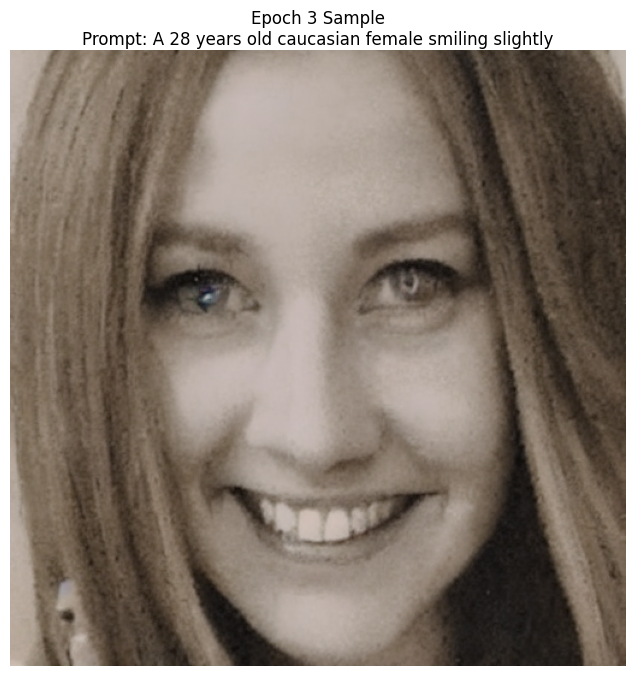

Updated training history saved to lora_training_runs/af641a_run_20250805-173847/training_history.json


Epoch 4/10:  88%|████████▊ | 1794/2033 [33:49<05:23,  1.35s/it]

In [ ]:
# --- To train from scratch ---
demo = train_lora_diffusion(
    num_epochs=10,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    dataset_for_sampling=train_dataset,
    learning_rate=3e-4,
    lora_r=128,
    lora_alpha=128,
    lora_dropout=0.05,
    gradient_checkpoint_enable=True,
    gradient_accumulation_steps=4, # Example: accumulate gradients over 4 steps
    output_base_dir=Path("./lora_training_runs"), # Change 'output_dir' to 'output_base_dir'
    # The 'sample_dir' parameter also needs to be removed from the call,
    # as it's now internally derived from 'output_base_dir' and 'run_dir'.
    resume_unet_checkpoint_path=None, # Set to None for training from scratch
    verbose=False,
    use_gradio=False  # <-- Enable Gradio here
)

# --- To resume training ---
# Assuming you have a checkpoint saved from a previous run, e.g., unet_lora_weights_epoch_5.pth
# demo = train_lora_diffusion(
#     num_epochs=20, # Train for 5 more epochs
#     train_dataloader=train_loader,
#     valid_dataloader=valid_loader,
#     dataset_for_sampling=train_dataset,
#     learning_rate=2e-5, # You might want a lower LR when resuming
#     lora_r=128,
#     lora_alpha=128,
#     lora_dropout=0.05,
#     gradient_checkpoint_enable=True,
#     gradient_accumulation_steps=4, # Example: accumulate gradients over 4 steps
#     output_base_dir=Path("./lora_training_runs"), # Change 'output_dir' to 'output_base_dir'
#     # Remove 'sample_dir' here too
#     resume_unet_checkpoint_path=Path("./lora_training_runs/YOUR_RUN_ID_HERE/lora_checkpoints/full_unet_checkpoint_epoch_X.pth"), # Update path to reflect new structure
#     verbose=False,
#     use_gradio=False  # <-- Enable Gradio here
# )

if demo:
    demo.launch(share=True) # Create public URL for Google Colab monitoring

In [ ]:
######################################
##### SET RUN_ID TO RESUME FROM ######
######################################
RESUME_RUN_ID = 'af641a_run_20250805-173847'
RESUME_EPOCH = 10

# --- To train from scratch ---
# demo = train_lora_diffusion(
#     num_epochs=10,
#     train_dataloader=train_loader,
#     valid_dataloader=valid_loader,
#     dataset_for_sampling=train_dataset,
#     learning_rate=3e-5,
#     lora_r=128,
#     lora_alpha=128,
#     lora_dropout=0.05,
#     gradient_checkpoint_enable=True,
#     gradient_accumulation_steps=4, # Example: accumulate gradients over 4 steps
#     output_base_dir=Path("./lora_training_runs"), # Change 'output_dir' to 'output_base_dir'
#     # The 'sample_dir' parameter also needs to be removed from the call,
#     # as it's now internally derived from 'output_base_dir' and 'run_dir'.
#     resume_unet_checkpoint_path=None, # Set to None for training from scratch
#     verbose=False,
#     use_gradio=True  # <-- Enable Gradio here
# )

# --- To resume training ---
# Assuming you have a checkpoint saved from a previous run, e.g., unet_lora_weights_epoch_5.pth
demo = train_lora_diffusion(
    num_epochs=30, # Train for 5 more epochs
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    dataset_for_sampling=train_dataset,
    learning_rate=5e-5, # You might want a lower LR when resuming
    lora_r=128,
    lora_alpha=128,
    lora_dropout=0.05,
    gradient_checkpoint_enable=True,
    gradient_accumulation_steps=4, # Example: accumulate gradients over 4 steps
    output_base_dir=Path("./lora_training_runs"), # Change 'output_dir' to 'output_base_dir'
    # Remove 'sample_dir' here too
    resume_unet_checkpoint_path=Path(f"./lora_training_runs/{RESUME_RUN_ID}/lora_checkpoints/full_unet_checkpoint_epoch_{RESUME_EPOCH}.pth"), # Update path to reflect new structure
    verbose=False,
    use_gradio=True  # <-- Enable Gradio here
)

if demo:
    demo.launch(share=True) # Create public URL for Google Colab monitoring